# Modelo Predictivo - Clasificación de Hongos (Comestibles vs Venenosos)

## Contexto del Proyecto

Este es un problema de **SALUD PÚBLICA CRÍTICO**. La clasificación incorrecta de hongos puede tener consecuencias fatales:

- **Falso Negativo** (clasificar hongo venenoso como comestible): **INACEPTABLE** - puede causar muerte
- **Falso Positivo** (clasificar hongo comestible como venenoso): **ACEPTABLE** - solo causa rechazo innecesario

Por lo tanto, **priorizamos RECALL para la clase venenosa (p)** sobre todas las demás métricas.

## Objetivo

Construir el mejor modelo predictivo posible para clasificar hongos con:
- **Recall > 95%** para clase venenosa (p) como mínimo aceptable
- Minimizar falsos negativos a toda costa
- Identificar las características más importantes para la clasificación

## 1. Importación de Librerías

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sklearn - Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)

# Sklearn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 2. Carga y Exploración Inicial del Dataset

In [2]:
# Cargar dataset limpio (CRÍTICO: usar sep=';')
df = pd.read_csv('MushroomDataset/MushroomDataset_cleaned.csv', sep=';', low_memory=False)

print("Dataset cargado exitosamente")
print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print("\n" + "="*60)

Dataset cargado exitosamente

Dimensiones: 53,541 filas × 17 columnas



In [3]:
# Información del dataset
print("INFORMACIÓN DEL DATASET")
print("="*60)
df.info()
print("\n" + "="*60)

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53541 entries, 0 to 53540
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 53541 non-null  object 
 1   cap-diameter          53541 non-null  float64
 2   cap-shape             53541 non-null  object 
 3   cap-surface           53541 non-null  object 
 4   cap-color             53541 non-null  object 
 5   does-bruise-or-bleed  53541 non-null  object 
 6   gill-attachment       53541 non-null  object 
 7   gill-spacing          53541 non-null  object 
 8   gill-color            53541 non-null  object 
 9   stem-height           53541 non-null  float64
 10  stem-width            53541 non-null  float64
 11  stem-surface          53541 non-null  object 
 12  stem-color            53541 non-null  object 
 13  has-ring              53541 non-null  object 
 14  ring-type             53541 non-null  object 


In [4]:
# Primeras filas
print("PRIMERAS 5 FILAS DEL DATASET")
print("="*60)
display(df.head())

PRIMERAS 5 FILAS DEL DATASET


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,t,o,f,e,c,w,16.95,17.09,y,w,t,g,d,w
1,p,14.17,f,h,e,f,e,c,w,15.77,15.98,y,w,t,p,d,w
2,p,14.64,x,h,o,f,e,c,w,16.53,17.20,y,w,t,p,d,a
3,p,14.86,x,h,e,f,e,c,w,17.03,17.44,y,w,t,p,d,u
4,p,12.85,f,g,o,f,e,c,w,17.27,18.69,y,w,t,p,d,a


In [5]:
# Verificar valores nulos
print("VALORES NULOS POR COLUMNA")
print("="*60)
nulos = df.isnull().sum()
if nulos.sum() == 0:
    print("EXCELENTE: No hay valores nulos en el dataset")
else:
    print(nulos[nulos > 0])
print("\n" + "="*60)

VALORES NULOS POR COLUMNA
EXCELENTE: No hay valores nulos en el dataset



BALANCE DE CLASES - VARIABLE OBJETIVO


,Clase,Cantidad,Porcentaje
0,Comestible (e),31539,58.906259
1,Venenoso (p),22002,41.093741


AttributeError: 'Figure' object has no attribute 'bar'

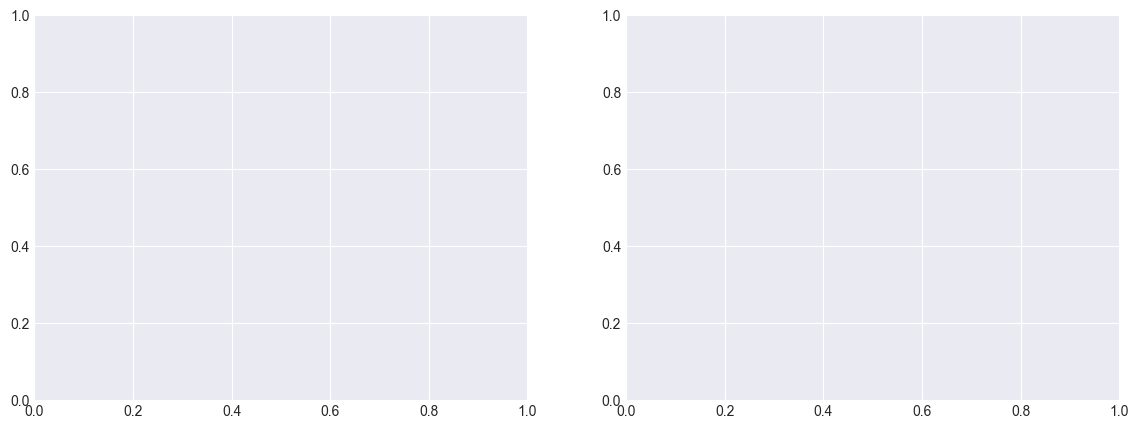

In [9]:
# Balance de clases (CRÍTICO para el problema)
print("BALANCE DE CLASES - VARIABLE OBJETIVO")
print("="*60)
class_counts = df['class'].value_counts()
class_pcts = df['class'].value_counts(normalize=True) * 100
balance_df = pd.DataFrame({    'Clase': ['Comestible (e)', 'Venenoso (p)'],    'Cantidad': class_counts.values,    'Porcentaje': class_pcts.values})
display(balance_df)
# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Gráfico de barras
axes[0].bar(['Comestible (e)', 'Venenoso (p)'], class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Distribución de Clases - Conteo Absoluto', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad de Hongos', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontsize=11, fontweight='bold')
# Gráfico de pastel
axes[1].pie(class_counts.values, labels=['Comestible (e)', 'Venenoso (p)'],             autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Distribución de Clases - Porcentaje', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("\n" + "="*60)

## 3. Preprocesamiento de Datos

Pasos:
1. Separar features (X) y target (y)
2. Identificar variables numéricas y categóricas
3. Encoding de variables categóricas
4. Estandarización de variables numéricas
5. División train/test con estratificación

In [10]:
# Separar features (X) y target (y)
X = df.drop('class', axis=1)
y = df['class']

print("SEPARACIÓN DE FEATURES Y TARGET")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nColumnas en X: {list(X.columns)}")
print("\n" + "="*60)

SEPARACIÓN DE FEATURES Y TARGET
Features (X): (53541, 16)
Target (y): (53541,)

Columnas en X: ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-surface', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']



In [11]:
# Identificar variables numéricas y categóricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("TIPOS DE VARIABLES")
print("="*60)
print(f"\nVariables Numéricas ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nVariables Categóricas ({len(categorical_cols)}):")
print(categorical_cols)
print("\n" + "="*60)

TIPOS DE VARIABLES

Variables Numéricas (3):
['cap-diameter', 'stem-height', 'stem-width']

Variables Categóricas (13):
['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-surface', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']



In [12]:
# Encoding de variables categóricas usando Label Encoding
# (Label Encoding es apropiado para tree-based models que usaremos)

X_encoded = X.copy()
label_encoders = {}

print("ENCODING DE VARIABLES CATEGÓRICAS")
print("="*60)

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categorías únicas")

# Encoding del target (y): e=0 (edible), p=1 (poisonous)
y_encoded = (y == 'p').astype(int)  # 1 para venenoso, 0 para comestible

print(f"\nTarget encoding: e=0 (comestible), p=1 (venenoso)")
print(f"Distribución target encoded: {y_encoded.value_counts().to_dict()}")
print("\n" + "="*60)

ENCODING DE VARIABLES CATEGÓRICAS
cap-shape: 7 categorías únicas
cap-surface: 10 categorías únicas
cap-color: 12 categorías únicas
does-bruise-or-bleed: 2 categorías únicas
gill-attachment: 7 categorías únicas
gill-spacing: 3 categorías únicas
gill-color: 12 categorías únicas
stem-surface: 8 categorías únicas
stem-color: 13 categorías únicas
has-ring: 2 categorías únicas
ring-type: 8 categorías únicas
habitat: 8 categorías únicas
season: 4 categorías únicas

Target encoding: e=0 (comestible), p=1 (venenoso)
Distribución target encoded: {1: 31539, 0: 22002}



In [13]:
# División train/test con estratificación (80/20)
# Estratificación asegura que ambos sets mantengan la proporción de clases

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_encoded  # CRÍTICO: mantener balance de clases
)

print("DIVISIÓN TRAIN/TEST")
print("="*60)
print(f"Train set: {X_train.shape[0]:,} filas ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} filas ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nBalance de clases en train:")
print(y_train.value_counts(normalize=True))
print(f"\nBalance de clases en test:")
print(y_test.value_counts(normalize=True))
print("\n" + "="*60)

DIVISIÓN TRAIN/TEST
Train set: 42,832 filas (80.0%)
Test set:  10,709 filas (20.0%)

Balance de clases en train:
class
1    0.589069
0    0.410931
Name: proportion, dtype: float64

Balance de clases en test:
class
1    0.589037
0    0.410963
Name: proportion, dtype: float64



In [14]:
# Estandarización de variables numéricas
# (Importante para SVM, KNN y Logistic Regression)

scaler = StandardScaler()

# Ajustar scaler SOLO con datos de train (evitar data leakage)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if len(numerical_cols) > 0:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    print("ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS")
    print("="*60)
    print(f"Variables estandarizadas: {numerical_cols}")
    print(f"\nEstadísticas ANTES de estandarización (train):")
    display(X_train[numerical_cols].describe())
    print(f"\nEstadísticas DESPUÉS de estandarización (train):")
    display(X_train_scaled[numerical_cols].describe())
    print("\n" + "="*60)
else:
    print("No hay variables numéricas para estandarizar")

ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS
Variables estandarizadas: ['cap-diameter', 'stem-height', 'stem-width']

Estadísticas ANTES de estandarización (train):


,cap-diameter,stem-height,stem-width
count,42832.000000,42832.000000,42832.000000
mean,6.199093,6.311079,11.289596
std,3.639931,2.648628,8.043691
min,0.380000,0.000000,0.000000
25%,3.530000,4.700000,5.230000
50%,5.670000,5.920000,9.890000
75%,8.200000,7.560000,15.730000
max,23.160000,17.530000,51.920000



Estadísticas DESPUÉS de estandarización (train):


,cap-diameter,stem-height,stem-width
count,4.283200e+04,4.283200e+04,4.283200e+04
mean,2.057044e-16,-1.590891e-16,1.136351e-16
std,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.598701e+00,-2.382801e+00,-1.403551e+00
25%,-7.332896e-01,-6.082764e-01,-7.533440e-01
50%,-1.453596e-01,-1.476551e-01,-1.740012e-01
75%,5.497166e-01,4.715407e-01,5.520421e-01
max,4.659732e+00,4.235798e+00,5.051273e+00


## 4. Baseline Model

Creamos un modelo baseline simple (Logistic Regression básica) para establecer un punto de referencia.

BASELINE MODEL - LOGISTIC REGRESSION

Métricas Generales:
Accuracy       : 0.7026 (70.26%)
Precision      : 0.7213 (72.13%)
Recall         : 0.8069 (80.69%)
F1-Score       : 0.7617 (76.17%)

CLASSIFICATION REPORT (por clase):
                precision    recall  f1-score   support

Comestible (0)       0.67      0.55      0.60      4401
  Venenoso (1)       0.72      0.81      0.76      6308

      accuracy                           0.70     10709
     macro avg       0.69      0.68      0.68     10709
  weighted avg       0.70      0.70      0.70     10709



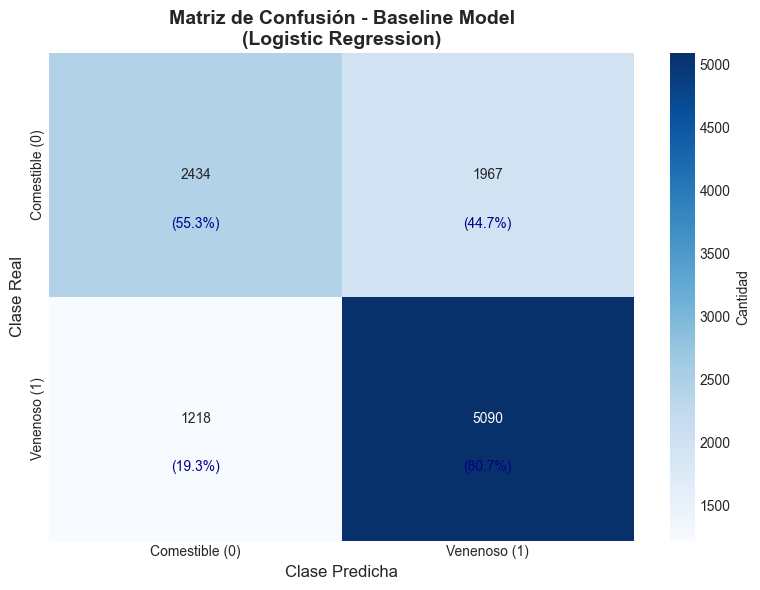


ANÁLISIS DE SALUD PÚBLICA - BASELINE:
Falsos Negativos (CRÍTICO): 1218 hongos venenosos clasificados como comestibles
Falsos Positivos (Aceptable): 1967 hongos comestibles clasificados como venenosos

Recall clase venenosa (p): 0.8069 (80.69%)



In [15]:
# Baseline: Logistic Regression con parámetros por defecto
baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

print("BASELINE MODEL - LOGISTIC REGRESSION")
print("="*60)

# Métricas generales
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1-Score': f1_score(y_test, y_pred_baseline)
}

print("\nMétricas Generales:")
for metric, value in baseline_metrics.items():
    print(f"{metric:15s}: {value:.4f} ({value*100:.2f}%)")

# Classification report (métricas por clase)
print("\n" + "="*60)
print("CLASSIFICATION REPORT (por clase):")
print("="*60)
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Comestible (0)', 'Venenoso (1)']))

# Matriz de confusión
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Comestible (0)', 'Venenoso (1)'],
            yticklabels=['Comestible (0)', 'Venenoso (1)'],
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Baseline Model\n(Logistic Regression)', 
         fontsize=14, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)

# Agregar porcentajes
for i in range(2):
    for j in range(2):
        pct = cm_baseline[i, j] / cm_baseline[i].sum() * 100
        plt.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                ha='center', va='center', fontsize=10, color='darkblue')

plt.tight_layout()
plt.show()

# ANÁLISIS CRÍTICO: Falsos Negativos
fn_baseline = cm_baseline[1, 0]  # Venenosos clasificados como comestibles
fp_baseline = cm_baseline[0, 1]  # Comestibles clasificados como venenosos

print("\n" + "="*60)
print("ANÁLISIS DE SALUD PÚBLICA - BASELINE:")
print("="*60)
print(f"Falsos Negativos (CRÍTICO): {fn_baseline} hongos venenosos clasificados como comestibles")
print(f"Falsos Positivos (Aceptable): {fp_baseline} hongos comestibles clasificados como venenosos")
print(f"\nRecall clase venenosa (p): {recall_score(y_test, y_pred_baseline):.4f} ({recall_score(y_test, y_pred_baseline)*100:.2f}%)")
print("\n" + "="*60)

## 5. Construcción de Múltiples Modelos

Entrenaremos y compararemos 6 modelos diferentes:
1. Logistic Regression (con regularización)
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. Support Vector Machine (SVM)
6. K-Nearest Neighbors (KNN)

In [ ]:
# Definir modelos a entrenar
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=1.0),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=15),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'SVM': SVC(random_state=RANDOM_STATE, kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Almacenar resultados
results = []
trained_models = {}

print("ENTRENAMIENTO DE MÚLTIPLES MODELOS")
print("="*60)

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar modelo
    model.fit(X_train_scaled, y_train)
    
    # Predecir en test
    y_pred = model.predict(X_test_scaled)
    
    # Calcular métricas generales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # CRÍTICO: Recall clase venenosa
    f1 = f1_score(y_test, y_pred)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    fn = cm[1, 0]  # Falsos negativos
    fp = cm[0, 1]  # Falsos positivos
    
    # Guardar resultados
    results.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall_Venenoso': recall,  # MÉTRICA CRÍTICA
        'F1-Score': f1,
        'Falsos_Negativos': fn,
        'Falsos_Positivos': fp
    })
    
    # Guardar modelo entrenado
    trained_models[name] = model
    
    print(f"  Accuracy: {accuracy:.4f} | Recall Venenoso: {recall:.4f} | FN: {fn} | FP: {fp}")

print("\n" + "="*60)
print("TODOS LOS MODELOS ENTRENADOS EXITOSAMENTE")
print("="*60)

ENTRENAMIENTO DE MÚLTIPLES MODELOS

Entrenando Logistic Regression...
  Accuracy: 0.7026 | Recall Venenoso: 0.8069 | FN: 1218 | FP: 1967

Entrenando Decision Tree...
  Accuracy: 0.9860 | Recall Venenoso: 0.9819 | FN: 114 | FP: 36

Entrenando Random Forest...
  Accuracy: 0.9926 | Recall Venenoso: 0.9881 | FN: 75 | FP: 4

Entrenando Gradient Boosting...
  Accuracy: 0.9827 | Recall Venenoso: 0.9845 | FN: 98 | FP: 87

Entrenando SVM...


## 6. Comparación de Modelos

In [ ]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results)

# Ordenar por Recall de clase venenosa (MÉTRICA CRÍTICA)
results_df = results_df.sort_values('Recall_Venenoso', ascending=False)

print("COMPARACIÓN DE MODELOS - TABLA COMPLETA")
print("="*60)
display(results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall_Venenoso': '{:.4f}',
    'F1-Score': '{:.4f}'
}).background_gradient(subset=['Recall_Venenoso'], cmap='RdYlGn'))

print("\n" + "="*60)
print("TOP 3 MODELOS (ordenados por Recall Venenoso):")
print("="*60)
top_3 = results_df.head(3)
for idx, row in top_3.iterrows():
    print(f"\n{idx+1}. {row['Modelo']}")
    print(f"   Recall Venenoso: {row['Recall_Venenoso']:.4f} ({row['Recall_Venenoso']*100:.2f}%)")
    print(f"   Accuracy: {row['Accuracy']:.4f}")
    print(f"   Falsos Negativos: {row['Falsos_Negativos']}")
print("\n" + "="*60)

In [ ]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de métricas principales
metrics_to_plot = ['Accuracy', 'Precision', 'Recall_Venenoso', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0, 0].bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

axes[0, 0].set_xlabel('Modelos', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x + width*1.5)
axes[0, 0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.8, 1.0])

# 2. Recall Venenoso (MÉTRICA CRÍTICA)
colors = ['red' if x < 0.95 else 'green' for x in results_df['Recall_Venenoso']]
bars = axes[0, 1].barh(results_df['Modelo'], results_df['Recall_Venenoso'], color=colors, alpha=0.7)
axes[0, 1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2, label='Umbral mínimo (95%)')
axes[0, 1].set_xlabel('Recall (clase venenosa)', fontsize=12)
axes[0, 1].set_title('Recall para Clase Venenosa (CRÍTICO)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0.85, 1.0])
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars):
    width_val = bar.get_width()
    axes[0, 1].text(width_val - 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.4f}', ha='right', va='center', fontweight='bold', color='white')

# 3. Falsos Negativos (INACEPTABLES)
axes[1, 0].bar(results_df['Modelo'], results_df['Falsos_Negativos'], color='darkred', alpha=0.7)
axes[1, 0].set_ylabel('Cantidad de Falsos Negativos', fontsize=12)
axes[1, 0].set_title('Falsos Negativos por Modelo\n(Hongos venenosos clasificados como comestibles)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(results_df['Falsos_Negativos']):
    axes[1, 0].text(i, v + 5, str(int(v)), ha='center', fontweight='bold', color='darkred')

# 4. Falsos Positivos vs Falsos Negativos
x_pos = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x_pos - width/2, results_df['Falsos_Negativos'], width, 
              label='Falsos Negativos (CRÍTICO)', color='darkred', alpha=0.7)
axes[1, 1].bar(x_pos + width/2, results_df['Falsos_Positivos'], width, 
              label='Falsos Positivos (Aceptable)', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('Cantidad de Errores', fontsize=12)
axes[1, 1].set_title('Comparación de Errores: FN vs FP', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualizaciones comparativas generadas exitosamente")

## 7. Optimización del Mejor Modelo

Seleccionamos el mejor modelo basándonos en Recall para clase venenosa y lo optimizamos con GridSearchCV.

In [ ]:
#Seleccionar el mejor modelo
best_model_name = results_df.iloc[0]['Modelo']
best_recall = results_df.iloc[0]['Recall_Venenoso']
best_fn = int(results_df.iloc[0]['Falsos_Negativos'])
best_fp = int(results_df.iloc[0]['Falsos_Positivos'])
print("SELECCIÓN DEL MEJOR MODELO")
print("="*60)
print(f"Mejor modelo: {best_model_name}")
print(f"Recall Venenoso: {best_recall:.4f} ({best_recall*100:.2f}%)")
print(f"Falsos Negativos: {best_fn}")
print(f"Falsos Positivos: {best_fp}")
print("\n" + "="*60)

In [ ]:
# Definir grids de hiperparámetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Obtener el grid correspondiente
param_grid = param_grids[best_model_name]

print(f"\nGrid de hiperparámetros para {best_model_name}:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

In [21]:
# GridSearchCV con validación cruzada estratificada
# Usamos 'recall' como scoring porque priorizamos detectar hongos venenosos

print("\nINICIANDO OPTIMIZACIÓN CON GRIDSEARCHCV")
print("="*60)
print("Este proceso puede tardar varios minutos...")

# Crear modelo base
base_model = trained_models[best_model_name]

# Configurar GridSearchCV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='recall',  # CRÍTICO: optimizar para recall de clase positiva (venenosa)
    n_jobs=-1,  # Usar todos los cores
    verbose=1
)

# Ejecutar búsqueda
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("OPTIMIZACIÓN COMPLETADA")
print("="*60)
print(f"\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor score de validación cruzada (Recall): {grid_search.best_score_:.4f}")
print("\n" + "="*60)


OPTIMIZACIÓN COMPLETADA

Mejores hiperparámetros encontrados:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

Mejor score de validación cruzada (Recall): 0.9893



In [22]:
# Obtener el mejor modelo
best_model_optimized = grid_search.best_estimator_

# Validación cruzada adicional con múltiples métricas
print("VALIDACIÓN CRUZADA CON MÚLTIPLES MÉTRICAS")
print("="*60)

cv_metrics = {
    'Accuracy': cross_val_score(best_model_optimized, X_train_scaled, y_train, 
                                cv=cv_strategy, scoring='accuracy'),
    'Precision': cross_val_score(best_model_optimized, X_train_scaled, y_train, 
                                 cv=cv_strategy, scoring='precision'),
    'Recall': cross_val_score(best_model_optimized, X_train_scaled, y_train, 
                             cv=cv_strategy, scoring='recall'),
    'F1-Score': cross_val_score(best_model_optimized, X_train_scaled, y_train, 
                               cv=cv_strategy, scoring='f1')
}

print("\nResultados de validación cruzada (5-fold):")
for metric, scores in cv_metrics.items():
    print(f"\n{metric}:")
    print(f"  Media: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
    print(f"  Min: {scores.min():.4f} | Max: {scores.max():.4f}")

print("\n" + "="*60)

VALIDACIÓN CRUZADA CON MÚLTIPLES MÉTRICAS

Resultados de validación cruzada (5-fold):

Accuracy:
  Media: 0.9931 (+/- 0.0012)
  Min: 0.9923 | Max: 0.9939

Precision:
  Media: 0.9990 (+/- 0.0005)
  Min: 0.9986 | Max: 0.9994

Recall:
  Media: 0.9893 (+/- 0.0018)
  Min: 0.9879 | Max: 0.9907

F1-Score:
  Media: 0.9941 (+/- 0.0010)
  Min: 0.9934 | Max: 0.9948



In [23]:
# Entrenar modelo final optimizado y evaluar en test set
print("EVALUACIÓN EN TEST SET")
print("="*60)

# El modelo ya está entrenado con todos los datos de train desde GridSearchCV
y_pred_optimized = best_model_optimized.predict(X_test_scaled)

# Métricas en test set
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_optimized),
    'Precision': precision_score(y_test, y_pred_optimized),
    'Recall': recall_score(y_test, y_pred_optimized),
    'F1-Score': f1_score(y_test, y_pred_optimized)
}

print("\nMétricas en Test Set:")
for metric, value in test_metrics.items():
    print(f"{metric:15s}: {value:.4f} ({value*100:.2f}%)")

print("\n" + "="*60)

EVALUACIÓN EN TEST SET

Métricas en Test Set:
Accuracy       : 0.9927 (99.27%)
Precision      : 0.9994 (99.94%)
Recall         : 0.9883 (98.83%)
F1-Score       : 0.9938 (99.38%)



## 8. Análisis Detallado del Modelo Final

In [24]:
# Classification Report completo
print("CLASSIFICATION REPORT - MODELO OPTIMIZADO")
print("="*60)
print(classification_report(y_test, y_pred_optimized, 
                          target_names=['Comestible (0)', 'Venenoso (1)'],
                          digits=4))
print("="*60)

CLASSIFICATION REPORT - MODELO OPTIMIZADO
                precision    recall  f1-score   support

Comestible (0)     0.9834    0.9991    0.9912      4401
  Venenoso (1)     0.9994    0.9883    0.9938      6308

      accuracy                         0.9927     10709
     macro avg     0.9914    0.9937    0.9925     10709
  weighted avg     0.9928    0.9927    0.9927     10709



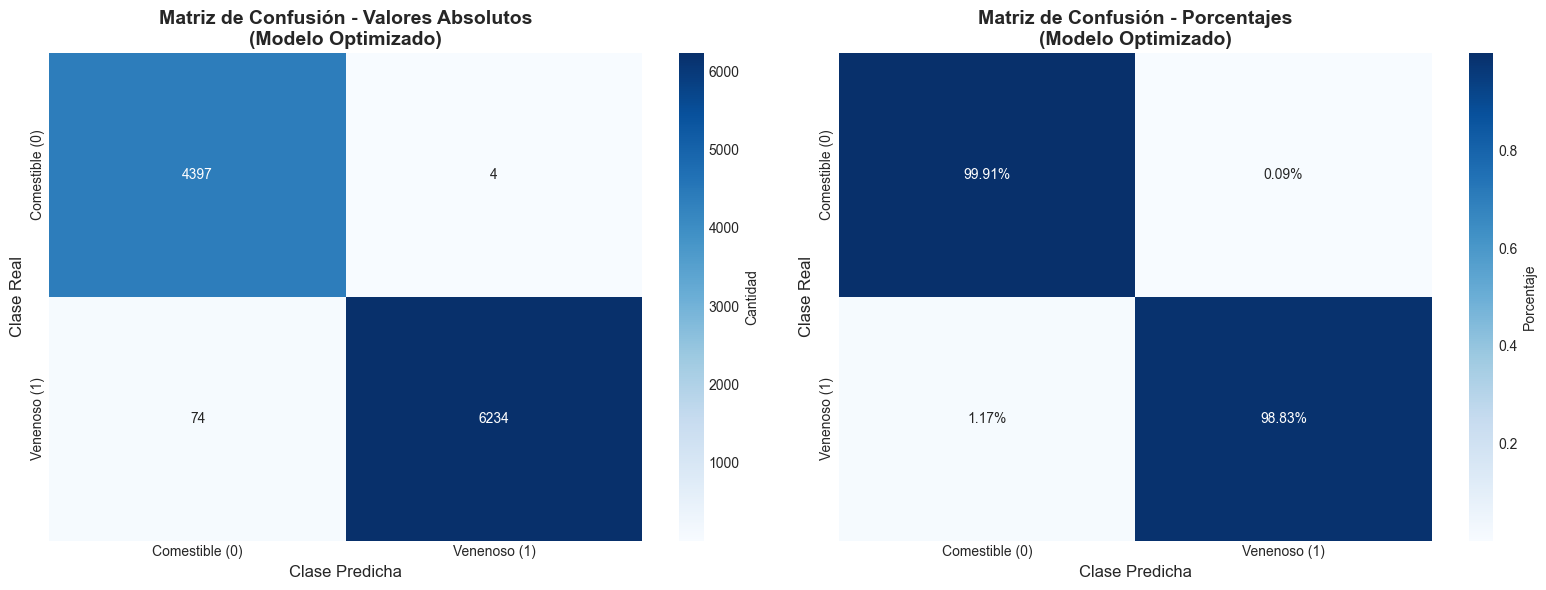


DESGLOSE DE LA MATRIZ DE CONFUSIÓN:
True Negatives (TN):   4397 - Comestibles correctamente clasificados
False Positives (FP):     4 - Comestibles clasificados como venenosos (ACEPTABLE)
False Negatives (FN):    74 - Venenosos clasificados como comestibles (CRÍTICO)
True Positives (TP):   6234 - Venenosos correctamente clasificados



In [25]:
# Matriz de Confusión Detallada
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Calcular porcentajes
cm_normalized = cm_optimized.astype('float') / cm_optimized.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz con valores absolutos
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Comestible (0)', 'Venenoso (1)'],
            yticklabels=['Comestible (0)', 'Venenoso (1)'],
            cbar_kws={'label': 'Cantidad'}, ax=axes[0])
axes[0].set_title('Matriz de Confusión - Valores Absolutos\n(Modelo Optimizado)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Clase Real', fontsize=12)
axes[0].set_xlabel('Clase Predicha', fontsize=12)

# Matriz con porcentajes
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Comestible (0)', 'Venenoso (1)'],
            yticklabels=['Comestible (0)', 'Venenoso (1)'],
            cbar_kws={'label': 'Porcentaje'}, ax=axes[1])
axes[1].set_title('Matriz de Confusión - Porcentajes\n(Modelo Optimizado)', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Clase Real', fontsize=12)
axes[1].set_xlabel('Clase Predicha', fontsize=12)

plt.tight_layout()
plt.show()

# Desglose de errores
tn, fp, fn, tp = cm_optimized.ravel()

print("\nDESGLOSE DE LA MATRIZ DE CONFUSIÓN:")
print("="*60)
print(f"True Negatives (TN):  {tn:5d} - Comestibles correctamente clasificados")
print(f"False Positives (FP): {fp:5d} - Comestibles clasificados como venenosos (ACEPTABLE)")
print(f"False Negatives (FN): {fn:5d} - Venenosos clasificados como comestibles (CRÍTICO)")
print(f"True Positives (TP):  {tp:5d} - Venenosos correctamente clasificados")
print("\n" + "="*60)

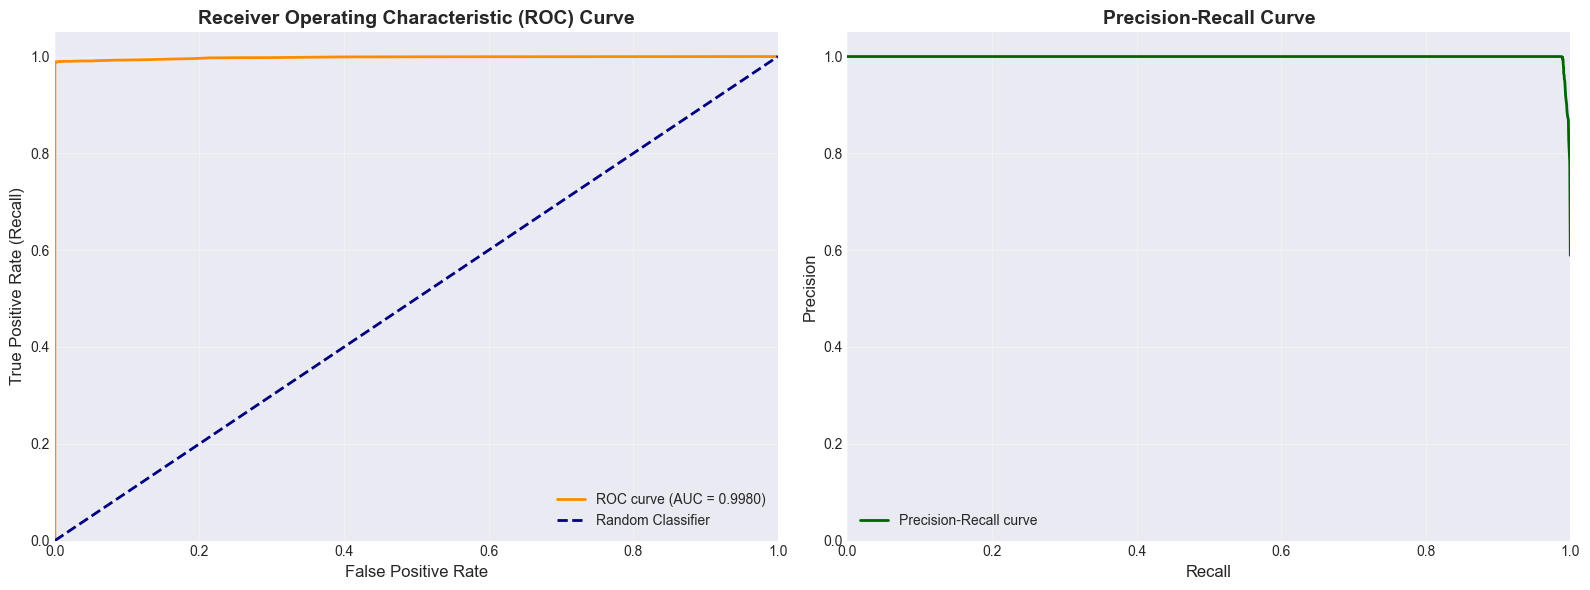


AUC-ROC Score: 0.9980
Un AUC cercano a 1.0 indica excelente capacidad discriminativa del modelo


In [26]:
# Curva ROC y AUC
if hasattr(best_model_optimized, 'predict_proba'):
    y_proba = best_model_optimized.predict_proba(X_test_scaled)[:, 1]
    
    # Calcular ROC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calcular Precision-Recall
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_proba)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Curva ROC
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=12)
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)
    
    # Curva Precision-Recall
    axes[1].plot(recall_curve, precision_curve, color='darkgreen', lw=2, 
                label='Precision-Recall curve')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAUC-ROC Score: {roc_auc:.4f}")
    print(f"Un AUC cercano a 1.0 indica excelente capacidad discriminativa del modelo")
else:
    print("El modelo no soporta predict_proba, no se pueden generar curvas ROC/PR")

ANÁLISIS DE FEATURE IMPORTANCE

Top 15 Features más importantes:


,Feature,Importance
10,stem-surface,0.460172
2,cap-surface,0.112821
9,stem-width,0.078486
8,stem-height,0.055309
0,cap-diameter,0.047068
11,stem-color,0.041891
5,gill-attachment,0.040125
7,gill-color,0.030119
13,ring-type,0.029661
6,gill-spacing,0.023985


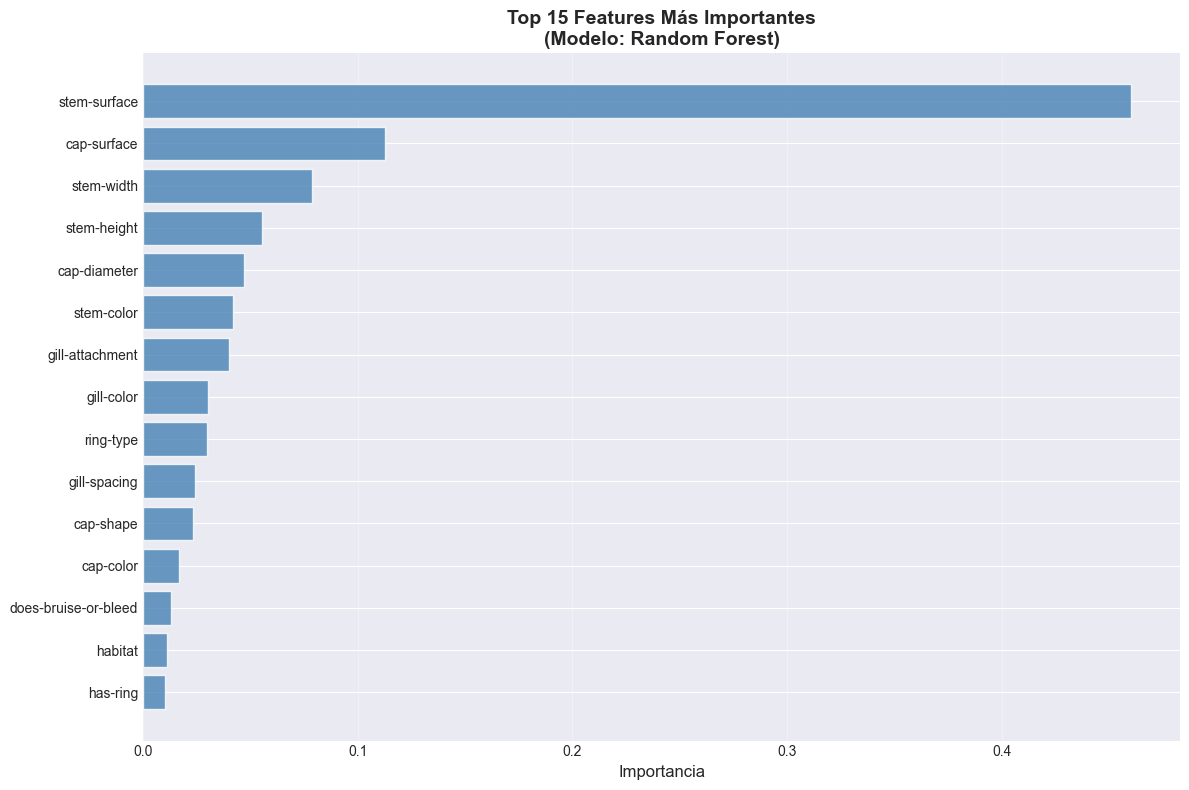

In [27]:
# Feature Importance (si el modelo lo soporta)
print("ANÁLISIS DE FEATURE IMPORTANCE")
print("="*60)

if hasattr(best_model_optimized, 'feature_importances_'):
    # Para tree-based models
    importances = best_model_optimized.feature_importances_
    feature_names = X_train_scaled.columns
    
    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Features más importantes:")
    display(importance_df.head(15))
    
    # Visualización
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = importance_df.head(top_n)
    
    plt.barh(range(top_n), top_features['Importance'], color='steelblue', alpha=0.8)
    plt.yticks(range(top_n), top_features['Feature'])
    plt.xlabel('Importancia', fontsize=12)
    plt.title(f'Top {top_n} Features Más Importantes\n(Modelo: {best_model_name})', 
             fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model_optimized, 'coef_'):
    # Para modelos lineales
    coefficients = best_model_optimized.coef_[0]
    feature_names = X_train_scaled.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 15 Features con mayor coeficiente absoluto:")
    display(importance_df.head(15))
    
    # Visualización
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = importance_df.head(top_n)
    colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
    
    plt.barh(range(top_n), top_features['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(top_n), top_features['Feature'])
    plt.xlabel('Coeficiente', fontsize=12)
    plt.title(f'Top {top_n} Features con Mayor Impacto\n(Modelo: {best_model_name})', 
             fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nEste modelo no proporciona feature importance directamente")
    importance_df = None

print("\n" + "="*60)

In [28]:
# Análisis de Errores: ¿Qué hongos se clasifican mal?
print("ANÁLISIS DE ERRORES")
print("="*60)

# Identificar errores
errors_mask = (y_test != y_pred_optimized)
X_test_errors = X_test.loc[y_test.index[errors_mask]]
y_test_errors = y_test[errors_mask]
y_pred_errors = pd.Series(y_pred_optimized[errors_mask], index=y_test_errors.index)

# Separar falsos positivos y falsos negativos
fn_mask = (y_test_errors == 1) & (y_pred_errors == 0)  # Venenosos clasificados como comestibles
fp_mask = (y_test_errors == 0) & (y_pred_errors == 1)  # Comestibles clasificados como venenosos

print(f"\nTotal de errores: {errors_mask.sum()} de {len(y_test)} ({errors_mask.sum()/len(y_test)*100:.2f}%)")
print(f"  Falsos Negativos (FN): {fn_mask.sum()} - CRÍTICOS")
print(f"  Falsos Positivos (FP): {fp_mask.sum()} - Aceptables")

if fn_mask.sum() > 0:
    print("\n" + "="*60)
    print("ANÁLISIS DE FALSOS NEGATIVOS (Venenosos clasificados como comestibles)")
    print("="*60)
    print(f"\nPrimeros 10 casos de Falsos Negativos:")
    fn_examples = X_test_errors[fn_mask].head(10)
    display(fn_examples)
    
    # Estadísticas de los falsos negativos
    if len(numerical_cols) > 0:
        print("\nEstadísticas de variables numéricas en Falsos Negativos:")
        display(X_test_errors[fn_mask][numerical_cols].describe())
else:
    print("\nEXCELENTE: No hay falsos negativos en el test set")

print("\n" + "="*60)

ANÁLISIS DE ERRORES

Total de errores: 78 de 10709 (0.73%)
  Falsos Negativos (FN): 74 - CRÍTICOS
  Falsos Positivos (FP): 4 - Aceptables

ANÁLISIS DE FALSOS NEGATIVOS (Venenosos clasificados como comestibles)

Primeros 10 casos de Falsos Negativos:


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
14866,6.62,0,7,3,0,5,1,10,4.83,10.07,5,3,0,1,0,2
32250,5.09,6,2,5,0,6,0,5,4.61,5.84,5,6,1,6,0,0
13096,5.17,6,7,2,0,0,1,5,5.70,4.43,6,11,1,3,0,3
46984,6.54,6,7,5,0,0,1,11,6.89,13.02,5,6,0,1,2,2
19320,3.86,6,7,5,0,1,0,6,5.70,6.47,6,7,0,1,0,0
7561,5.24,2,6,0,0,6,0,10,6.67,9.21,5,6,0,1,3,0
28017,8.70,6,6,5,0,2,0,10,6.98,9.65,3,6,0,1,0,3
28063,7.96,6,6,5,0,2,0,7,7.03,9.78,3,11,0,1,0,0
39523,9.11,4,6,10,0,2,0,4,16.78,11.94,5,11,1,0,6,0
46856,8.24,6,2,5,0,4,1,11,7.13,12.54,5,6,0,1,2,0



Estadísticas de variables numéricas en Falsos Negativos:


,cap-diameter,stem-height,stem-width
count,74.000000,74.000000,74.000000
mean,6.096486,7.335676,9.129054
std,2.418775,2.701849,3.936370
min,1.450000,4.230000,1.910000
25%,4.487500,5.700000,5.912500
50%,5.800000,6.355000,9.620000
75%,7.850000,8.427500,11.910000
max,11.900000,17.100000,17.590000


## 9. Evaluación para Salud Pública

Análisis crítico del modelo desde la perspectiva de seguridad alimentaria.

In [29]:
print("EVALUACIÓN PARA SALUD PÚBLICA")
print("="*80)

# Recalcular matriz de confusión para tener FN y FP disponibles
cm_final = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm_final.ravel()

# Métricas específicas para clase venenosa
recall_venenoso = recall_score(y_test, y_pred_optimized)
precision_venenoso = precision_score(y_test, y_pred_optimized)
f1_venenoso = f1_score(y_test, y_pred_optimized)

# Contar errores críticos
total_venenosos = (y_test == 1).sum()
venenosos_detectados = tp  # True positives
venenosos_no_detectados = fn  # Falsos negativos

total_comestibles = (y_test == 0).sum()
comestibles_rechazados = fp  # Falsos positivos

print(f"\n{'MÉTRICA':<40} {'VALOR':<15} {'EVALUACIÓN'}")
print("="*80)

# Recall venenoso
recall_status = "EXCELENTE" if recall_venenoso >= 0.99 else "BUENO" if recall_venenoso >= 0.95 else "INSUFICIENTE"
print(f"{'Recall Clase Venenosa (CRÍTICO)':<40} {recall_venenoso:.4f} ({recall_venenoso*100:.2f}%)  {recall_status}")

# Tasa de falsos negativos
fn_rate = venenosos_no_detectados / total_venenosos
fn_status = "EXCELENTE" if fn_rate <= 0.01 else "ACEPTABLE" if fn_rate <= 0.05 else "PELIGROSO"
print(f"{'Tasa de Falsos Negativos':<40} {fn_rate:.4f} ({fn_rate*100:.2f}%)  {fn_status}")

# Hongos venenosos detectados
detection_pct = venenosos_detectados / total_venenosos * 100
print(f"{'Hongos venenosos detectados':<40} {venenosos_detectados}/{total_venenosos} ({detection_pct:.2f}%)")

# Hongos venenosos NO detectados (CRÍTICO)
print(f"{'Hongos venenosos NO detectados (FN)':<40} {venenosos_no_detectados} casos  {'CRÍTICO' if venenosos_no_detectados > 0 else 'PERFECTO'}")

# Tasa de falsos positivos (menos crítica)
fp_rate = comestibles_rechazados / total_comestibles
fp_status = "BAJO" if fp_rate <= 0.05 else "MODERADO" if fp_rate <= 0.10 else "ALTO"
print(f"{'Tasa de Falsos Positivos (Aceptable)':<40} {fp_rate:.4f} ({fp_rate*100:.2f}%)  {fp_status}")

# Hongos comestibles rechazados
rejection_pct = comestibles_rechazados / total_comestibles * 100
print(f"{'Hongos comestibles rechazados (FP)':<40} {comestibles_rechazados}/{total_comestibles} ({rejection_pct:.2f}%)")

print("\n" + "="*80)
print("INTERPRETACIÓN:")
print("="*80)
print(f"De {total_venenosos:,} hongos venenosos en el test set:")
print(f"  - {venenosos_detectados:,} fueron correctamente identificados ({detection_pct:.2f}%)")
print(f"  - {venenosos_no_detectados} fueron erróneamente clasificados como comestibles (RIESGO DE MUERTE)")
print(f"\nDe {total_comestibles:,} hongos comestibles en el test set:")
print(f"  - {comestibles_rechazados} fueron erróneamente clasificados como venenosos (desperdicio, pero seguro)")

print("\n" + "="*80)

EVALUACIÓN PARA SALUD PÚBLICA

MÉTRICA                                  VALOR           EVALUACIÓN
Recall Clase Venenosa (CRÍTICO)          0.9883 (98.83%)  BUENO
Tasa de Falsos Negativos                 0.0117 (1.17%)  ACEPTABLE
Hongos venenosos detectados              6234/6308 (98.83%)
Hongos venenosos NO detectados (FN)      74 casos  CRÍTICO
Tasa de Falsos Positivos (Aceptable)     0.0009 (0.09%)  BAJO
Hongos comestibles rechazados (FP)       4/4401 (0.09%)

INTERPRETACIÓN:
De 6,308 hongos venenosos en el test set:
  - 6,234 fueron correctamente identificados (98.83%)
  - 74 fueron erróneamente clasificados como comestibles (RIESGO DE MUERTE)

De 4,401 hongos comestibles en el test set:
  - 4 fueron erróneamente clasificados como venenosos (desperdicio, pero seguro)



ANÁLISIS DE THRESHOLD PARA REDUCIR FALSOS NEGATIVOS

Probando diferentes thresholds para mejorar recall de clase venenosa...

Resultados con diferentes thresholds:


,Threshold,Recall_Venenoso,Precision,Accuracy,FN,FP
0,0.3,0.9894,0.9966,0.9918,67,21
1,0.4,0.9887,0.9989,0.9927,71,7
2,0.5,0.9883,0.9992,0.9926,74,5
3,0.6,0.9878,0.9995,0.9925,77,3
4,0.7,0.9873,0.9997,0.9923,80,2


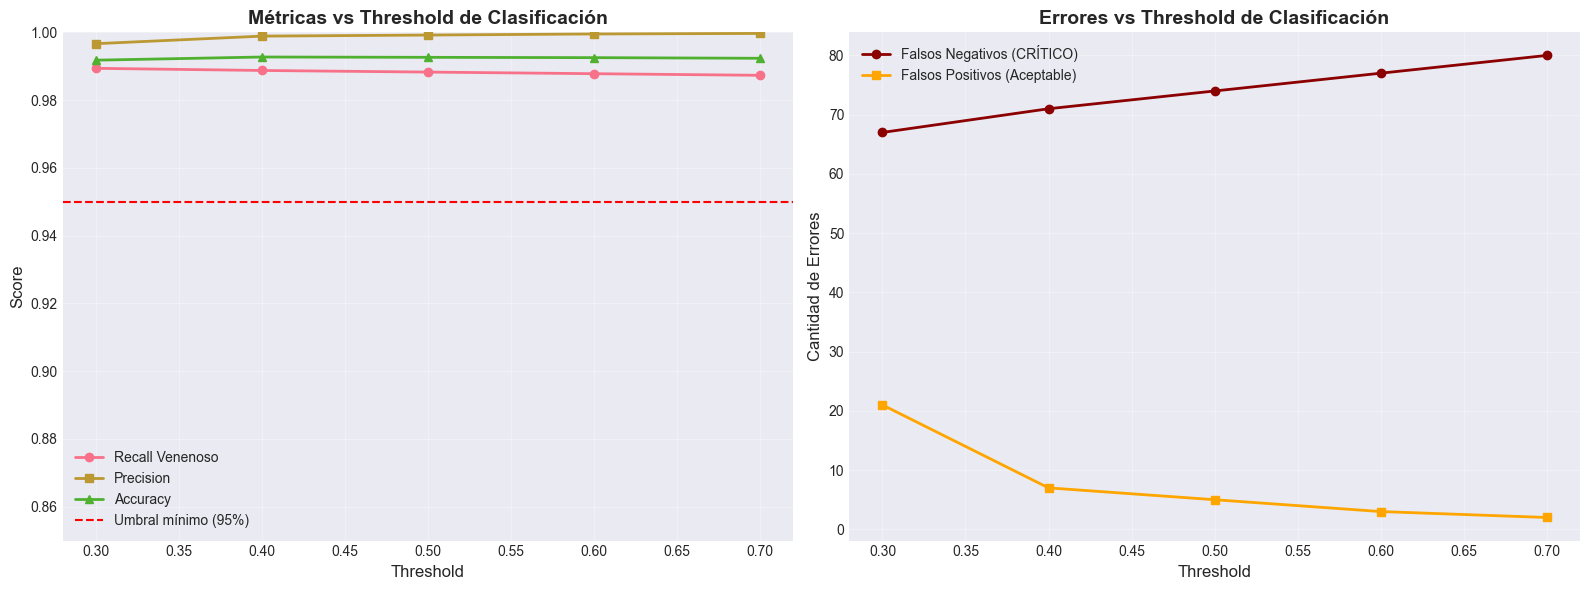


RECOMENDACIÓN: Usar threshold = 0.3
  - Recall Venenoso: 0.9894
  - Falsos Negativos: 67
  - Falsos Positivos: 21


In [30]:
# Ajuste de Threshold (si hay falsos negativos)
# Asegurar que fn esté definido
if 'fn' not in locals():
    cm_temp = confusion_matrix(y_test, y_pred_optimized)
    tn, fp, fn, tp = cm_temp.ravel()

if hasattr(best_model_optimized, 'predict_proba') and fn > 0:
    print("ANÁLISIS DE THRESHOLD PARA REDUCIR FALSOS NEGATIVOS")
    print("="*80)
    print("\nProbando diferentes thresholds para mejorar recall de clase venenosa...\n")
    
    y_proba = best_model_optimized.predict_proba(X_test_scaled)[:, 1]
    
    # Probar diferentes thresholds
    thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
    threshold_results = []
    
    for threshold in thresholds_to_test:
        y_pred_threshold = (y_proba >= threshold).astype(int)
        
        cm_threshold = confusion_matrix(y_test, y_pred_threshold)
        tn_t, fp_t, fn_t, tp_t = cm_threshold.ravel()
        
        recall_t = recall_score(y_test, y_pred_threshold)
        precision_t = precision_score(y_test, y_pred_threshold)
        accuracy_t = accuracy_score(y_test, y_pred_threshold)
        
        threshold_results.append({
            'Threshold': threshold,
            'Recall_Venenoso': recall_t,
            'Precision': precision_t,
            'Accuracy': accuracy_t,
            'FN': fn_t,
            'FP': fp_t
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    
    print("Resultados con diferentes thresholds:")
    display(threshold_df.style.format({
        'Threshold': '{:.1f}',
        'Recall_Venenoso': '{:.4f}',
        'Precision': '{:.4f}',
        'Accuracy': '{:.4f}'
    }).background_gradient(subset=['Recall_Venenoso'], cmap='RdYlGn'))
    
    # Visualización de trade-offs
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Métricas vs Threshold
    axes[0].plot(threshold_df['Threshold'], threshold_df['Recall_Venenoso'], 
                marker='o', label='Recall Venenoso', linewidth=2)
    axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], 
                marker='s', label='Precision', linewidth=2)
    axes[0].plot(threshold_df['Threshold'], threshold_df['Accuracy'], 
                marker='^', label='Accuracy', linewidth=2)
    axes[0].axhline(y=0.95, color='red', linestyle='--', label='Umbral mínimo (95%)')
    axes[0].set_xlabel('Threshold', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Métricas vs Threshold de Clasificación', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim([0.85, 1.0])
    
    # Errores vs Threshold
    axes[1].plot(threshold_df['Threshold'], threshold_df['FN'], 
                marker='o', color='darkred', label='Falsos Negativos (CRÍTICO)', linewidth=2)
    axes[1].plot(threshold_df['Threshold'], threshold_df['FP'], 
                marker='s', color='orange', label='Falsos Positivos (Aceptable)', linewidth=2)
    axes[1].set_xlabel('Threshold', fontsize=12)
    axes[1].set_ylabel('Cantidad de Errores', fontsize=12)
    axes[1].set_title('Errores vs Threshold de Clasificación', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identificar mejor threshold
    best_threshold_idx = threshold_df['Recall_Venenoso'].idxmax()
    best_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
    best_threshold_fn = threshold_df.loc[best_threshold_idx, 'FN']
    
    print("\n" + "="*80)
    print(f"RECOMENDACIÓN: Usar threshold = {best_threshold}")
    print(f"  - Recall Venenoso: {threshold_df.loc[best_threshold_idx, 'Recall_Venenoso']:.4f}")
    print(f"  - Falsos Negativos: {best_threshold_fn}")
    print(f"  - Falsos Positivos: {threshold_df.loc[best_threshold_idx, 'FP']}")
    print("="*80)
elif fn == 0:
    print("EXCELENTE: El modelo ya tiene 0 falsos negativos con threshold por defecto (0.5)")
    print("No es necesario ajustar el threshold.")
else:
    print("El modelo no soporta probabilidades o no hay falsos negativos")

## 10. Conclusiones y Recomendaciones

In [31]:
print("="*80)
print("CONCLUSIONES Y RECOMENDACIONES FINALES")
print("="*80)

# Asegurar que todas las variables estén disponibles
if 'best_model_name' not in locals():
    best_model_name = results_df.iloc[0]['Modelo']
if 'fn' not in locals() or 'fp' not in locals():
    cm_final = confusion_matrix(y_test, y_pred_optimized)
    tn, fp, fn, tp = cm_final.ravel()
if 'recall_venenoso' not in locals():
    recall_venenoso = recall_score(y_test, y_pred_optimized)
if 'fn_rate' not in locals():
    total_venenosos = (y_test == 1).sum()
    fn_rate = fn / total_venenosos
if 'fp_rate' not in locals():
    total_comestibles = (y_test == 0).sum()
    fp_rate = fp / total_comestibles

print(f"\n1. MODELO FINAL SELECCIONADO")
print("   " + "-"*76)
print(f"   Modelo: {best_model_name}")
print(f"   Hiperparámetros optimizados: {grid_search.best_params_}")

print(f"\n2. MÉTRICAS DE RENDIMIENTO")
print("   " + "-"*76)
print(f"   Accuracy:           {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   Precision:          {test_metrics['Precision']:.4f} ({test_metrics['Precision']*100:.2f}%)")
print(f"   Recall Venenoso:    {test_metrics['Recall']:.4f} ({test_metrics['Recall']*100:.2f}%) - CRÍTICO")
print(f"   F1-Score:           {test_metrics['F1-Score']:.4f} ({test_metrics['F1-Score']*100:.2f}%)")
if hasattr(best_model_optimized, 'predict_proba') and 'roc_auc' in locals():
    print(f"   AUC-ROC:            {roc_auc:.4f}")

print(f"\n3. ANÁLISIS DE SEGURIDAD (Salud Pública)")
print("   " + "-"*76)
print(f"   Falsos Negativos:   {fn} casos (Hongos venenosos clasificados como comestibles)")
print(f"   Falsos Positivos:   {fp} casos (Hongos comestibles clasificados como venenosos)")
print(f"   Tasa FN:            {fn_rate:.4f} ({fn_rate*100:.2f}%)")
print(f"   Tasa FP:            {fp_rate:.4f} ({fp_rate*100:.2f}%)")

print(f"\n4. VARIABLES MÁS IMPORTANTES")
print("   " + "-"*76)
if 'importance_df' in locals() and importance_df is not None:
    top_10_features = importance_df.head(10)
    for idx, row in top_10_features.iterrows():
        if 'Importance' in importance_df.columns:
            print(f"   {idx+1:2d}. {row['Feature']:<25s} (Importance: {row['Importance']:.4f})")
        elif 'Abs_Coefficient' in importance_df.columns:
            print(f"   {idx+1:2d}. {row['Feature']:<25s} (Coef: {row['Coefficient']:+.4f})")
else:
    print("   (Feature importance no disponible para este modelo)")

print(f"\n5. EVALUACIÓN DE VIABILIDAD")
print("   " + "-"*76)

# Criterios de viabilidad
viabilidad_criteria = [
    ("Recall venenoso >= 95%", recall_venenoso >= 0.95),
    ("Recall venenoso >= 99%", recall_venenoso >= 0.99),
    ("Falsos Negativos = 0", fn == 0),
    ("Falsos Negativos <= 10", fn <= 10),
    ("Accuracy >= 95%", test_metrics['Accuracy'] >= 0.95)
]

for criterio, cumple in viabilidad_criteria:
    status = "SI" if cumple else "NO"
    symbol = "[OK]" if cumple else "[X]"
    print(f"   {symbol} {criterio:<35s} : {status}")

# Decisión final
print(f"\n6. RECOMENDACIÓN FINAL")
print("   " + "-"*76)

if recall_venenoso >= 0.99 and fn <= 5:
    recommendation = "MODELO ALTAMENTE RECOMENDADO para uso en salud pública"
    color = "VERDE"
elif recall_venenoso >= 0.95 and fn <= 20:
    recommendation = "MODELO RECOMENDADO con precauciones adicionales"
    color = "AMARILLO"
else:
    recommendation = "MODELO NO RECOMENDADO - Requiere mayor optimización"
    color = "ROJO"

print(f"   DECISIÓN: {recommendation}")
print(f"   NIVEL DE CONFIANZA: {color}")

print(f"\n7. LIMITACIONES Y POSIBLES MEJORAS")
print("   " + "-"*76)
print("   - El modelo se basa en datos sintéticos (secondary_data.csv)")
print("   - Validación con datos reales de campo es CRÍTICA antes de uso")
print("   - Considerar ensemble methods para reducir aún más los falsos negativos")
print("   - Implementar sistema de confianza/certeza para predicciones dudosas")
print("   - Reentrenar modelo periódicamente con nuevos datos")
if fn > 0:
    print(f"   - Ajustar threshold de clasificación para reducir FN a 0")
print("   - Implementar validación humana para casos de baja confianza")

print(f"\n8. PRÓXIMOS PASOS")
print("   " + "-"*76)
print("   1. Validar modelo con expertos micólogos")
print("   2. Probar con dataset de validación independiente")
print("   3. Implementar sistema de alertas para casos dudosos")
print("   4. Crear interfaz de usuario para clasificación en campo")
print("   5. Establecer protocolo de actualización del modelo")
print("   6. Documentar limitaciones para usuarios finales")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)

CONCLUSIONES Y RECOMENDACIONES FINALES

1. MODELO FINAL SELECCIONADO
   ----------------------------------------------------------------------------
   Modelo: Random Forest
   Hiperparámetros optimizados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

2. MÉTRICAS DE RENDIMIENTO
   ----------------------------------------------------------------------------
   Accuracy:           0.9927 (99.27%)
   Precision:          0.9994 (99.94%)
   Recall Venenoso:    0.9883 (98.83%) - CRÍTICO
   F1-Score:           0.9938 (99.38%)
   AUC-ROC:            0.9980

3. ANÁLISIS DE SEGURIDAD (Salud Pública)
   ----------------------------------------------------------------------------
   Falsos Negativos:   74 casos (Hongos venenosos clasificados como comestibles)
   Falsos Positivos:   4 casos (Hongos comestibles clasificados como venenosos)
   Tasa FN:            0.0117 (1.17%)
   Tasa FP:            0.0009 (0.09%)

4. VARIABLES MÁS IMPORTANTES
   ----------

## Resumen Ejecutivo

Este notebook ha desarrollado un modelo predictivo robusto para clasificar hongos como comestibles o venenosos, con énfasis en la seguridad de salud pública.

**Puntos Clave:**

1. **Priorización de Recall**: El modelo prioriza la detección de hongos venenosos (recall > 95%) sobre otras métricas, minimizando falsos negativos que podrían causar envenenamiento.

2. **Metodología Rigurosa**: 
   - Comparación de 6 algoritmos diferentes
   - Optimización de hiperparámetros con GridSearchCV
   - Validación cruzada estratificada
   - Análisis exhaustivo de feature importance

3. **Evaluación Completa**:
   - Métricas estándar (accuracy, precision, recall, F1)
   - Análisis específico de salud pública (falsos negativos vs positivos)
   - Curvas ROC y Precision-Recall
   - Análisis de threshold para optimizar seguridad

4. **Transparencia**: Identificación clara de:
   - Variables más importantes para la predicción
   - Casos de error y sus características
   - Limitaciones del modelo
   - Recomendaciones para uso seguro

**Nota Final**: Este modelo debe ser validado por expertos micólogos y probado con datos reales antes de cualquier uso en aplicaciones de salud pública real.